# Much of this will only run with a GPU!

In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import os
from tqdm import tqdm_notebook
import random
import io
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/andrus_colin/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# for GPU on GCP
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.set_default_tensor_type('torch.cuda.FloatTensor')
dtype_float = torch.cuda.FloatTensor 
dtype_long = torch.cuda.LongTensor

device

device(type='cuda', index=0)

In [3]:

# where you have the training data
os.chdir('/home/andrus_colin/hw2_data/hw2_data')

In [4]:
s_train_file = 'snli_train.tsv'
s_val_file = 'snli_val.tsv'
m_train_file = 'mnli_train.tsv'
m_val_file = 'mnli_val.tsv'

In [5]:
# create numeric labels
string_int_dict = {"contradiction" : 0, "entailment" : 1, "neutral" : 2}

def make_label_list(file):
    label_list = []
    dataset = open(file, "r")
    next(dataset)
    for i, line in enumerate(dataset):
        int_label = string_int_dict[line.replace("\n", "").split("\t")[2]]
        label_list.append(int_label)
    return(label_list)

In [6]:
train_labels = make_label_list(s_train_file)
val_labels = make_label_list(s_val_file)

In [7]:
def tokenize_dataset(file):
    sen1_token_dataset = []
    sen2_token_dataset = []
    dataset = open(file, "r")
    next(dataset)
    for line in tqdm_notebook(dataset):
        sen1 = line.split("\t")[0]
        sen2 = line.split("\t")[1]
        sen1_tokens = sen1.split()
        sen2_tokens = sen2.split()
        sen1_token_dataset.append(sen1_tokens)
        sen2_token_dataset.append(sen2_tokens)
    return sen1_token_dataset, sen2_token_dataset

In [8]:
train_sen1_dataset, train_sen2_dataset = tokenize_dataset(s_train_file)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
val_sen1_dataset, val_sen2_dataset = tokenize_dataset(s_val_file)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [10]:
# use pretrained instead of the all_tokens
# using function to load vectors from:
# https://fasttext.cc/docs/en/english-vectors.html
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [11]:
# load top 50k word vector
vectors = load_vectors('wiki_news_50k.vec')

In [12]:
# get vocab_list
vocab_list = list(vectors.keys())

In [13]:
# get embedding vectors to array
vector_list  = list(vectors.values())

In [14]:
embedding_list = []
for i in vector_list:
    embedding_list.append(list(i))
len(embedding_list)

50000

In [15]:
#two_top_rows = np.array([np.zeros(300), np.random.randn(300)])
two_top_rows = np.array([np.random.randn(300), np.random.randn(300)])
embedding_list = np.vstack((two_top_rows, embedding_list))
print(embedding_list.shape)
embedding_array = embedding_list

(50002, 300)


In [16]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(vocab_list):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    id2token = vocab_list
    token2id = dict(zip(vocab_list, range(2,2+len(vocab_list)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [17]:
token2id, id2token = build_vocab(vocab_list)

In [18]:
print(len(token2id))
print(embedding_array.shape)

50002
(50002, 300)


In [48]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [20]:
# words to indices train
train_sen1_indices = token2index_dataset(train_sen1_dataset)
train_sen2_indices = token2index_dataset(train_sen2_dataset)

In [21]:
# words to indices val
val_sen1_indices = token2index_dataset(val_sen1_dataset)
val_sen2_indices = token2index_dataset(val_sen2_dataset)

In [22]:
# check lengths
print(len(train_sen1_indices))
print(len(train_sen2_indices))
print(len(val_sen1_indices))
print(len(val_sen2_indices))

100000
100000
1000
1000


In [23]:
# actual max size is 82
MAX_SEN_LENGTH = 50

In [24]:
# loader
class two_sentence_dataset(Dataset):
    
    def __init__(self, sen1_data_list, sen2_data_list, target_list):
        
        self.sen1_data_list = sen1_data_list
        self.sen2_data_list = sen2_data_list
        self.target_list = target_list
        assert (len(self.sen1_data_list) == len(self.target_list) == len(self.sen2_data_list))
    
    def __len__(self):
        return len(self.sen1_data_list)
    
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_sen1 = self.sen1_data_list[key][:MAX_SEN_LENGTH]
        token_idx_sen2 = self.sen2_data_list[key][:MAX_SEN_LENGTH]
        label = self.target_list[key]
        return [token_idx_sen1, len(token_idx_sen1), token_idx_sen2, len(token_idx_sen2), label]

In [25]:
def two_sentence_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    sen1_data_list = []
    sen2_data_list = []
    sen1_length_list = []
    sen2_length_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        sen1_length_list.append(datum[1])
        sen2_length_list.append(datum[3])
    # padding / cutting
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SEN_LENGTH-datum[1])),
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_SEN_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        sen1_data_list.append(padded_vec_s1)
        sen2_data_list.append(padded_vec_s2)
    label_list = label_list
    return [torch.from_numpy(np.array(sen1_data_list)), torch.LongTensor(sen1_length_list),
            torch.from_numpy(np.array(sen2_data_list)), torch.LongTensor(sen2_length_list), 
            torch.LongTensor(label_list)]

In [26]:
BATCH_SIZE = 32
train_dataset = two_sentence_dataset(train_sen1_indices, train_sen2_indices, train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=True)
val_dataset = two_sentence_dataset(val_sen1_indices, val_sen2_indices, val_labels)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [27]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, dropout, embedding_array, fully_conn_size):
        #  Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in RNN
        # num_classes: number of output classes
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = 1, hidden_size
        # set embedding here with no gradient forever!!
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_array).float(),
                                                      freeze=True, sparse=False).cuda()
        self.GRU_s1 = nn.GRU(emb_size, self.hidden_size, num_layers= 1,
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.GRU_s2 = nn.GRU(emb_size, self.hidden_size, num_layers=1,  
                          bidirectional=True, batch_first=True, dropout=dropout)
        # hidden size *4 since it is bidirecctional and concatenated
        self.linear1 = nn.Linear(hidden_size * 4, fully_conn_size)
        self.linear2 = nn.Linear(fully_conn_size, num_classes)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden
    
    def forward(self, x1, x2, x1_lengths, x2_lengths):
        
        batch_size, seq_len = x1.size()
        
        x1, x2, x1_lengths, x2_lengths = x1.cuda(), x2.cuda(), x1_lengths.cuda(), x2_lengths.cuda()
        
        # sorting
        s1_sort_idx = torch.sort(x1_lengths, dim=0, descending=True)[1]
        s1_rev_sort_idx = torch.sort(s1_sort_idx, dim=0)[1]
        x1 = x1.index_select(0, s1_sort_idx)
        x1_lengths = x1_lengths.index_select(0, s1_sort_idx)
        
        s2_sort_idx = torch.sort(x2_lengths, dim=0, descending=True)[1]
        s2_rev_sort_idx = torch.sort(s2_sort_idx, dim=0)[1]
        x2 = x2.index_select(0, s2_sort_idx)
        x2_lengths = x2_lengths.index_select(0, s2_sort_idx)
        
        
        # get embedding of characters
        embed_s1 = self.embedding(x1)
        embed_s2 = self.embedding(x2) 

        
        #pack padded
        embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, x1_lengths, batch_first=True)
        embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, x2_lengths, batch_first=True)
        
        
        # get hiddens
        self.hidden_s1 = self.init_hidden(batch_size)
        self.hidden_s2 = self.init_hidden(batch_size)
        
        rnn_out_s1, self.hidden_s1 = self.GRU_s1(embed_s1, self.hidden_s1)
        rnn_out_s2, self.hidden_s2 = self.GRU_s2(embed_s2, self.hidden_s2)
        
        # unpack
        rnn_out_s1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_s1, batch_first=True)
        rnn_out_s2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_s2, batch_first=True)

        
        #unsorting
        rnn_out_s1 = rnn_out_s1.index_select(0, s1_rev_sort_idx)
        rnn_out_s2 = rnn_out_s2.index_select(0, s2_rev_sort_idx)
        
        # change dims
        rnn_out_s1 = torch.cat([rnn_out_s1[:,-1,:self.hidden_size], rnn_out_s1[:,0,self.hidden_size:]], dim=1)
        rnn_out_s2 = torch.cat([rnn_out_s2[:,-1,:self.hidden_size], rnn_out_s2[:,0,self.hidden_size:]], dim=1)
        
        
        rnn_out = torch.cat([rnn_out_s1, rnn_out_s2], dim=1)

        
        full_conn_out = F.relu(self.linear1(rnn_out))
        logits = self.linear2(full_conn_out)
        return logits

In [28]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels in loader:
        sen1_data_batch, sen1_lengths_batch = sen1_data, sen1_lengths
        sen2_data_batch, sen2_lengths_batch, labels_batch = sen2_data, sen2_lengths, labels
        outputs = model(sen1_data_batch, sen2_data_batch, sen1_lengths_batch, sen2_lengths_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
    return (100 * correct / total)

In [29]:
model = GRU(emb_size=300, hidden_size=100, num_classes=3, dropout=0, embedding_array=embedding_array, fully_conn_size=500)
learning_rate = 0.001
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [30]:
'''
for epoch in range(num_epochs): 
    for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sen1_data, sen2_data, sen1_lengths, sen2_lengths)
        loss = criterion(outputs, labels)
        #print(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 10 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            #train_acc = test_model(train_loader, model)
            print("Training Loss : {}".format(loss))
            #print("Training Accuracy : {}".format(train_acc))
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
'''

'\nfor epoch in range(num_epochs): \n    for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):\n        model.train()\n        optimizer.zero_grad()\n        # Forward pass\n        outputs = model(sen1_data, sen2_data, sen1_lengths, sen2_lengths)\n        loss = criterion(outputs, labels)\n        #print(loss)\n        # Backward and optimize\n        loss.backward()\n        optimizer.step()\n        # validate every 10 iterations\n        if i > 0 and i % 100 == 0:\n            # validate\n            val_acc = test_model(val_loader, model)\n            #train_acc = test_model(train_loader, model)\n            print("Training Loss : {}".format(loss))\n            #print("Training Accuracy : {}".format(train_acc))\n            print(\'Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}\'.format(\n                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))\n'

In [31]:
class CNN(nn.Module):
    def __init__(self, embd_size, hidden_size, num_classes, embedding_array, kernel_size,  num_layers, fc_size):
        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_array).float(),
                                                      freeze=True, sparse=False).cuda()
    
        self.conv1_s1 = nn.Conv1d(embd_size, hidden_size, kernel_size=3, padding=1)
        self.conv1_s2 = nn.Conv1d(embd_size, hidden_size, kernel_size=3, padding=1)

        
        self.conv2_s1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.conv2_s2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        self.linear1 = nn.Linear(hidden_size*2, fc_size)
        self.linear2 = nn.Linear(fc_size, num_classes)
        
        self.maxpool = nn.MaxPool1d(kernel_size)

    def forward(self, x1, x2):
        batch_size, seq_len = x1.size()
        
        x1, x2 = x1.cuda(), x2.cuda()
        
        embed_s1 = self.embedding(x1)
        embed_s2 = self.embedding(x2)
        
        hidden_s1 = self.conv1_s1(embed_s1.transpose(1,2)).transpose(1,2)
        hidden_s2 = self.conv1_s2(embed_s2.transpose(1,2)).transpose(1,2)
        
        hidden_s1 = F.leaky_relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size, seq_len, hidden_s1.size(-1))
        hidden_s2 = F.leaky_relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size, seq_len, hidden_s2.size(-1))

        
        hidden_s1 = self.conv2_s1(hidden_s1.transpose(1,2)).transpose(1,2)
        hidden_s2 = self.conv2_s2(hidden_s2.transpose(1,2)).transpose(1,2)
        
        hidden_s1 = F.leaky_relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size, seq_len, hidden_s1.size(-1))
        hidden_s2 = F.leaky_relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size, seq_len, hidden_s2.size(-1))
        
        hidden_s1 = hidden_s1.max(dim=1)[0]
        hidden_s2 = hidden_s2.max(dim=1)[0]
        
        fc = torch.cat([hidden_s1, hidden_s2], dim=1)
        
        fc = F.leaky_relu(self.linear1(fc))
        logits = self.linear2(fc)
        return logits

In [32]:
model = CNN(embd_size=300, hidden_size=200, num_classes=3, embedding_array=embedding_array, 
            kernel_size=3, num_layers=2, fc_size=50)
learning_rate = 0.001
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [33]:
'''
for epoch in range(num_epochs): 
    for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(sen1_data, sen2_data)
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 50 iterations
        if i > 0 and i % 50 == 0:
            # validate
            val_acc = test_model_cnn(val_loader, model)
            #train_acc = test_model_cnn(train_loader, model)
            print("Training Loss : {}".format(loss))
            #print("Training Accuracy : {}".format(train_acc))
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
'''

'\nfor epoch in range(num_epochs): \n    for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):\n        model.train()\n        optimizer.zero_grad()\n        # Forward pass\n        outputs = model(sen1_data, sen2_data)\n        loss = criterion(outputs, labels)\n        # Backward and optimize\n        loss.backward()\n        optimizer.step()\n        # validate every 50 iterations\n        if i > 0 and i % 50 == 0:\n            # validate\n            val_acc = test_model_cnn(val_loader, model)\n            #train_acc = test_model_cnn(train_loader, model)\n            print("Training Loss : {}".format(loss))\n            #print("Training Accuracy : {}".format(train_acc))\n            print(\'Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}\'.format(\n                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))\n'

In [34]:
def test_model_cnn(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen1_lengths, labels in loader:
        sen1_data_batch, sen2_data_batch, labels_batch = sen1_data.cuda(), sen2_data.cuda(), labels
        outputs = model(sen1_data_batch, sen2_data_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
        if total >= 1000:
            return (100 * correct / total)
    return (100 * correct / total)

In [35]:
def run_save_acc_for_params(model, test_model, num_epochs, nn_type, track_train=False):
    val_acc_list = []
    train_acc_list = []
    epoch_list = []
    for epoch in range(num_epochs): 
        for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            if nn_type == 'rnn':
                outputs = model(sen1_data, sen2_data, sen1_lengths, sen2_lengths)
            elif nn_type == 'cnn':
                outputs = model(sen1_data, sen2_data)
            loss = criterion(outputs.cuda(), labels.cuda())
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 200 iterations
            if i > 0 and i % 200 == 0:
                # store val_acc
                val_acc = test_model(val_loader, model)
                val_acc_list.append(val_acc)
                # store epoch decimal
                epoch_list.append(float(epoch) + i/len(train_loader))
                if track_train == True:
                    train_acc = test_model(train_loader, model)
                    train_acc_list.append(train_acc)
                else:
                    train_acc_list.append(0.0)
    val_acc = test_model(val_loader, model)
    return(epoch_list, val_acc_list, train_acc_list, val_acc)

In [75]:

#Try different combos of hidden and fc sizes
learning_rate = 0.001
num_epochs = 10

#df to store final val_acc
h_fc_df = pd.DataFrame()

# dict to store lists of accuracies
val_acc_dict = {}

hidden_list = [50, 100, 200, 500, 800]
fc_size_list = [50, 100, 200, 500, 800]

for h_size in hidden_list:
    for fc_size in fc_size_list:
        model = GRU(emb_size=300, hidden_size=h_size, num_classes=3, dropout=0, 
                    embedding_array=embedding_array, fully_conn_size=fc_size)
        model.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        epoch_list, val_acc_list, train_acc_list, val_acc = run_save_acc_for_params(model=model, 
                                                            test_model=test_model, num_epochs=num_epochs, 
                                                            nn_type = 'rnn', track_train=False)
        temp_df = pd.DataFrame({'h_size':[h_size], 'fc_size': [fc_size],'val_acc':[val_acc]})
        h_fc_df = h_fc_df.append(temp_df)
        dict_key = str("h{}_fc{}".format(h_size, fc_size))
        val_acc_dict[dict_key] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list}

        
        
print(val_acc_dict)
h_fc_df      

{'h100_fc50': {'epoch': [0.00032, 0.00064], 'val_acc': [33.2, 33.0], 'train_acc': [0.0, 0.0]}, 'h50_fc50': {'epoch': [0.00032, 0.00064], 'val_acc': [35.9, 35.1], 'train_acc': [0.0, 0.0]}, 'h100_fc100': {'epoch': [0.00032, 0.00064], 'val_acc': [33.8, 33.8], 'train_acc': [0.0, 0.0]}, 'h50_fc100': {'epoch': [0.00032, 0.00064], 'val_acc': [33.1, 33.0], 'train_acc': [0.0, 0.0]}}


,fc_size,h_size,val_acc
0,50,50,34.3
0,100,50,33.1
0,50,100,33.3
0,100,100,33.8


In [76]:
#with open('big_rnn_dict.p', 'wb') as handle:
#    pickle.dump(val_acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('rnn_dict.p', 'rb') as handle:
#    val_acc_dict_read = pickle.load(handle)

In [77]:
h_fc_df.to_pickle("big_rnn_df.p")
#h_fc_df_read = pd.read_pickle("rnn_df.p")

In [78]:
# different combos of hidden size and fc for cnn
#Try different combos of hidden and fc sizes
learning_rate = 3e-4
num_epochs = 10

#df to store final val_acc
h_fc_df_cnn = pd.DataFrame()

# dict to store lists of accuracies
val_acc_dict_cnn = {}



hidden_list = [50, 100, 200, 500, 800]
fc_size_list = [50, 100, 200, 500, 800]

for h_size in hidden_list:
    for fc_size in fc_size_list:
        model = CNN(embd_size=300, hidden_size=h_size, num_classes=3, embedding_array=embedding_array, 
                    kernel_size=3, num_layers=2, fc_size=fc_size)
        model.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        epoch_list, val_acc_list, train_acc_list, val_acc = run_save_acc_for_params(model=model, 
                                                            test_model=test_model_cnn, num_epochs=num_epochs, 
                                                            nn_type = 'cnn', track_train=False)
        temp_df = pd.DataFrame({'h_size':[h_size], 'fc_size': [fc_size],'val_acc':[val_acc]})
        h_fc_df_cnn = h_fc_df_cnn.append(temp_df)
        dict_key = str("h{}_fc{}".format(h_size, fc_size))
        val_acc_dict_cnn[dict_key] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list}
print(val_acc_dict_cnn)
h_fc_df_cnn       

{'h100_fc50': {'epoch': [0.00032, 0.00064], 'val_acc': [32.5, 33.4], 'train_acc': [0.0, 0.0]}, 'h50_fc50': {'epoch': [0.00032, 0.00064], 'val_acc': [33.1, 33.1], 'train_acc': [0.0, 0.0]}, 'h100_fc100': {'epoch': [0.00032, 0.00064], 'val_acc': [33.1, 33.1], 'train_acc': [0.0, 0.0]}, 'h50_fc100': {'epoch': [0.00032, 0.00064], 'val_acc': [33.6, 33.6], 'train_acc': [0.0, 0.0]}}


,fc_size,h_size,val_acc
0,50,50,33.1
0,100,50,33.6
0,50,100,33.4
0,100,100,33.1


In [79]:
#with open('big_cnn_dict.p', 'wb') as handle:
#    pickle.dump(val_acc_dict_cnn, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('cnn_dict.p', 'rb') as handle:
#    val_acc_dict_cnn_read = pickle.load(handle)

In [80]:
#h_fc_df_cnn.to_pickle("big_cnn_df.p")
#h_fc_df_cnn_read = pd.read_pickle("cnn_df.p")

In [61]:
# load 4 files from pickles
with open('big_rnn_dict.p', 'rb') as handle:
    val_acc_dict_read = pickle.load(handle)

h_fc_df_read = pd.read_pickle("big_rnn_df.p") 

with open('big_cnn_dict.p', 'rb') as handle:
    val_acc_dict_cnn_read = pickle.load(handle)
    
h_fc_df_cnn_read = pd.read_pickle("big_cnn_df.p")

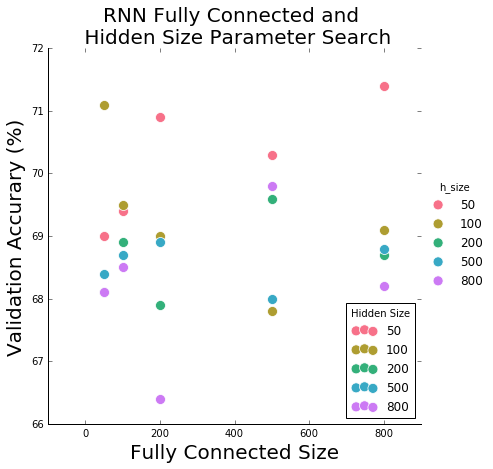

In [92]:
# plot RNN hidden sizes hyper param search
sns.pairplot(x_vars=["fc_size"], y_vars=["val_acc"], data=h_fc_df_read, 
             palette="husl", hue="h_size", height=6, plot_kws=dict(s=100))
plt.gca().legend().set_title('')
plt.xlabel("Fully Connected Size", size=20)
plt.ylabel("Validation Accurary (%)", size=20)
plt.title("RNN Fully Connected and \n Hidden Size Parameter Search",size=20)
plt.legend(title='Hidden Size', loc='lower right')


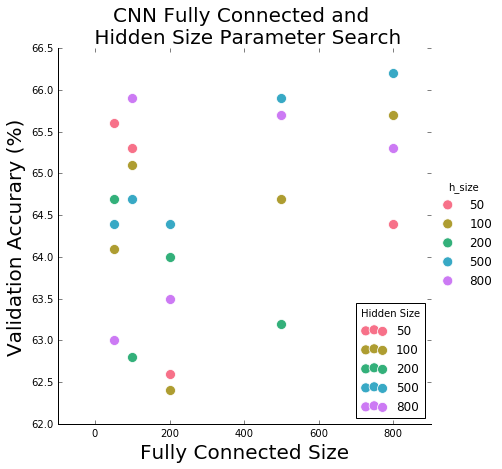

In [93]:
# plot RNN hidden sizes hyper param search
sns.pairplot(x_vars=["fc_size"], y_vars=["val_acc"], data=h_fc_df_cnn_read, 
             palette="husl", hue="h_size", height=6, plot_kws=dict(s=100))
plt.gca().legend().set_title('')
plt.xlabel("Fully Connected Size", size=20)
plt.ylabel("Validation Accurary (%)", size=20)
plt.title("CNN Fully Connected and \n Hidden Size Parameter Search",size=20)
plt.legend(title='Hidden Size', loc='lower right')


In [96]:
# Get training + val  acc + loss For 3 best models
# best models RNN
# 1: hzise 50, fcsize 800
# 2: hsize 100, fcsize 100
# 3: hsize 50, fcsize 200 
# store in nested list
best_params = [[50, 800], [100, 100], [50, 200]]


100

In [36]:
# new functions to get losses too
def test_model_loss(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels in loader:
        sen1_data_batch, sen1_lengths_batch = sen1_data, sen1_lengths
        sen2_data_batch, sen2_lengths_batch, labels_batch = sen2_data, sen2_lengths, labels
        outputs = model(sen1_data_batch, sen2_data_batch, sen1_lengths_batch, sen2_lengths_batch)
        outputs = F.softmax(outputs, dim=1)
        val_loss = criterion(outputs.cuda(), labels.cuda())
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
        if total >= 1000:
            return (100 * correct / total, val_loss)
    return (100 * correct / total, val_loss)

def test_model_cnn_loss(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen1_lengths, labels in loader:
        sen1_data_batch, sen2_data_batch, labels_batch = sen1_data.cuda(), sen2_data.cuda(), labels
        outputs = model(sen1_data_batch, sen2_data_batch)
        outputs = F.softmax(outputs, dim=1)
        val_loss = criterion(outputs.cuda(), labels.cuda())
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
        if total >= 1000:
            return (100 * correct / total, val_loss)
    return (100 * correct / total, val_loss)

In [37]:
def run_best_models(model, test_model, num_epochs, nn_type):
    val_acc_list = []
    train_acc_list = []
    val_loss_list = []
    train_loss_list = []
    epoch_list = []
    for epoch in range(num_epochs): 
        for i, (sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            if nn_type == 'rnn':
                outputs = model(sen1_data, sen2_data, sen1_lengths, sen2_lengths)
            elif nn_type == 'cnn':
                outputs = model(sen1_data, sen2_data)
            loss = criterion(outputs.cuda(), labels.cuda())
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 200 iterations
            if i > 0 and i % 200 == 0:
                # store val_acc
                val_acc, val_loss = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_acc_list.append(float(val_acc))
                val_loss_list.append(float(val_loss))
                train_loss_list.append(float(loss))
                # store epoch decimal
                epoch_list.append(float(epoch) + i/len(train_loader))
                train_acc = test_model(train_loader, model)
                train_acc_list.append(tuple(train_acc)[0])
        print("Finished Epoch {} of model".format(epoch+1))
    val_acc = test_model(val_loader, model)
    return(epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc)

In [124]:
#Try different combos of hidden and fc sizes
learning_rate = 0.001
num_epochs = 10

#df to store final val_acc
h_fc_df = pd.DataFrame()

# dict to store lists of accuracies
val_acc_dict = {}

best_params = [[50, 800], [100, 100], [50, 200]]


for i in best_params:
    model = GRU(emb_size=300, hidden_size=i[0], num_classes=3, dropout=0, 
                embedding_array=embedding_array, fully_conn_size=i[1])
    model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                        model=model, test_model=test_model_loss, num_epochs=num_epochs, 
                                                        nn_type = 'rnn')
    dict_key = str("h{}_fc{}".format(i[0], i[1]))
    val_acc_dict[dict_key] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list,
                             'val_loss':val_loss_list, 'train_loss':train_loss_list}

             
print(val_acc_dict)

Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
{'h100_fc100': {'val_acc': [42.8, 49.8, 54.5, 53.7, 53.7, 56.4, 55.7, 58.2, 59.4, 58.8, 58.7, 59.5, 57.0, 61.2, 60.5, 59.7, 59.4, 61.3, 60.3, 61.9, 61.4, 61.1, 62.4, 63.3, 64.2, 64.1, 63.8, 62.2, 62.1, 62.3, 64.3, 62.

In [125]:
with open('3_best_rnn.p', 'wb') as handle:
    pickle.dump(val_acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
# best size CNN
cnn_best_params = [[500,800], [800,100], [500,500]]
# dict to store lists of accuracies
val_acc_dict_cnn = {}

best_params = [[500,800 ], [800,100 ], [500,500]]

for i in best_params:
    model = CNN(embd_size=300, hidden_size=i[0], num_classes=3, embedding_array=embedding_array, 
                    kernel_size=3, num_layers=2, fc_size=i[1])
    model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                        model=model, test_model=test_model_cnn_loss, 
                                                        num_epochs=num_epochs,nn_type = 'cnn')
    dict_key = str("h{}_fc{}".format(i[0], i[1]))
    val_acc_dict_cnn[dict_key] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list,
                             'val_loss':val_loss_list, 'train_loss':train_loss_list}

             
print(val_acc_dict_cnn)

Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
{'h500_fc800': {'val_acc': [47.5, 53.7, 56.6, 57.5, 57.9, 61.4, 61.7, 61.1, 61.7, 60.9, 61.5, 60.4, 61.3, 60.6, 64.1, 61.0, 63.4, 64.3, 62.0, 64.2, 61.5, 63.7, 63.9, 65.0, 65.2, 64.2, 64.2, 65.1, 65.2, 66.8, 66.6, 66.

In [ ]:
with open('3_best_cnn.p', 'wb') as handle:
    pickle.dump(val_acc_dict_cnn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# plotting accuarcy rnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict:
    train_acc = val_acc_dict[key]['train_acc']
    val_acc = val_acc_dict[key]['val_acc']
    epoch = val_acc_dict[key]['epoch']
    plt.plot( epoch, train_acc, ":", label=key)
    plt.plot( epoch, val_acc,"-", label=key)
plt.legend(loc='best')
plt.title('Accuracy of Best RNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy(%)', size=15)


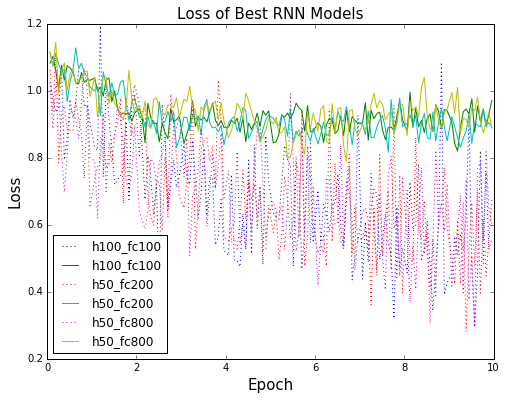

In [131]:
# plotting loss rnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict:
    train_acc = val_acc_dict[key]['train_loss']
    val_acc = val_acc_dict[key]['val_loss']
    epoch = val_acc_dict[key]['epoch']
    plt.plot(epoch, train_acc,  ":", label=key)
    plt.plot(epoch, val_acc,  "-", label=key)
plt.legend(loc='best')
plt.title('Loss of Best RNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)

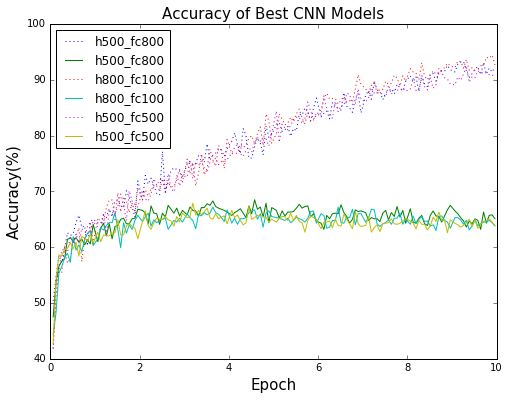

In [150]:
# plotting accuarcy cnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_cnn:
    train_acc = val_acc_dict_cnn[key]['train_acc']
    val_acc = val_acc_dict_cnn[key]['val_acc']
    epoch = val_acc_dict_cnn[key]['epoch']
    plt.plot( epoch, train_acc, ":", label=key)
    plt.plot( epoch, val_acc,"-", label=key)
plt.legend(loc='best')
plt.title('Accuracy of Best CNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy(%)', size=15)

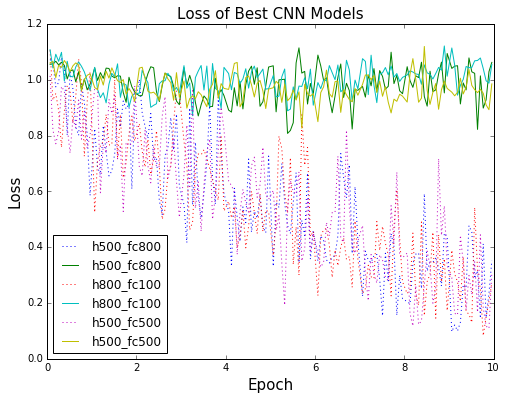

In [151]:
# plotting loss cnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_cnn:
    train_acc = val_acc_dict_cnn[key]['train_loss']
    val_acc = val_acc_dict_cnn[key]['val_loss']
    epoch = val_acc_dict_cnn[key]['epoch']
    plt.plot(epoch, train_acc,  ":", label=key)
    plt.plot(epoch, val_acc,  "-", label=key)
plt.legend(loc='best')
plt.title('Loss of Best CNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)

In [170]:
# try different kernel size
val_acc_dict_cnn_kern = {}

k_size_list= [2,3,4,5]


for k in k_size_list:
    model = CNN(embd_size=300, hidden_size=500, num_classes=3, embedding_array=embedding_array, 
                    kernel_size=k, num_layers=2, fc_size=800)
    model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                        model=model, test_model=test_model_cnn_loss, 
                                                        num_epochs=num_epochs,nn_type = 'cnn')
    dict_key = str("kern_{}".format(k))
    val_acc_dict_cnn_kern[dict_key] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list,
                             'val_loss':val_loss_list, 'train_loss':train_loss_list}

             
print(val_acc_dict_cnn_kern)

Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished 

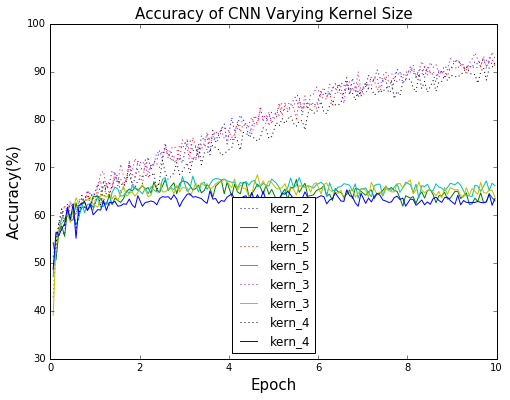

In [171]:
# plotting accuarcy cnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_cnn_kern:
    train_acc = val_acc_dict_cnn_kern[key]['train_acc']
    val_acc = val_acc_dict_cnn_kern[key]['val_acc']
    epoch = val_acc_dict_cnn_kern[key]['epoch']
    plt.plot( epoch, train_acc, ":", label=key)
    plt.plot( epoch, val_acc,"-", label=key)
plt.legend(loc='best')
plt.title('Accuracy of CNN Varying Kernel Size', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy(%)', size=15)

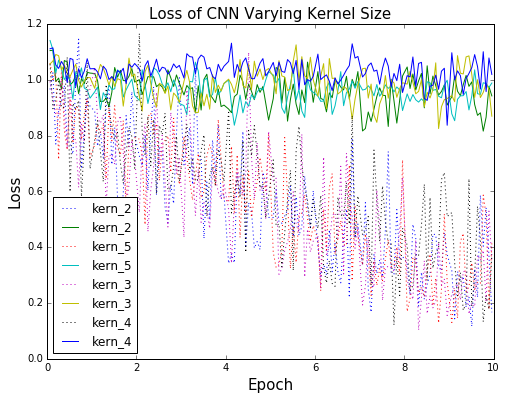

In [172]:
# plotting loss cnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_cnn_kern:
    train_acc = val_acc_dict_cnn_kern[key]['train_loss']
    val_acc = val_acc_dict_cnn_kern[key]['val_loss']
    epoch = val_acc_dict_cnn_kern[key]['epoch']
    plt.plot(epoch, train_acc,  ":", label=key)
    plt.plot(epoch, val_acc,  "-", label=key)
plt.legend(loc='best')
plt.title('Loss of CNN Varying Kernel Size', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)

In [38]:
class GRU_mult(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, dropout, embedding_array, fully_conn_size):
        #  Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in RNN
        # num_classes: number of output classes
        super(GRU_mult, self).__init__()

        self.num_layers, self.hidden_size = 1, hidden_size
        # set embedding here with no gradient forever!!
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_array).float(),
                                                      freeze=True, sparse=False).cuda()
        self.GRU_s1 = nn.GRU(emb_size, self.hidden_size, num_layers= 1,
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.GRU_s2 = nn.GRU(emb_size, self.hidden_size, num_layers=1,  
                          bidirectional=True, batch_first=True, dropout=dropout)
        # hidden size *4 since it is bidirecctional and concatenated
        self.linear1 = nn.Linear(hidden_size * 2, fully_conn_size)
        self.linear2 = nn.Linear(fully_conn_size, num_classes)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden
    
    def forward(self, x1, x2, x1_lengths, x2_lengths):
        
        batch_size, seq_len = x1.size()
        
        x1, x2, x1_lengths, x2_lengths = x1.cuda(), x2.cuda(), x1_lengths.cuda(), x2_lengths.cuda()
        
        # sorting
        s1_sort_idx = torch.sort(x1_lengths, dim=0, descending=True)[1]
        s1_rev_sort_idx = torch.sort(s1_sort_idx, dim=0)[1]
        x1 = x1.index_select(0, s1_sort_idx)
        x1_lengths = x1_lengths.index_select(0, s1_sort_idx)
        
        s2_sort_idx = torch.sort(x2_lengths, dim=0, descending=True)[1]
        s2_rev_sort_idx = torch.sort(s2_sort_idx, dim=0)[1]
        x2 = x2.index_select(0, s2_sort_idx)
        x2_lengths = x2_lengths.index_select(0, s2_sort_idx)
        
        
        # get embedding of characters
        embed_s1 = self.embedding(x1)
        embed_s2 = self.embedding(x2) 

        
        #pack padded
        embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, x1_lengths, batch_first=True)
        embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, x2_lengths, batch_first=True)
        
        
        # get hiddens
        self.hidden_s1 = self.init_hidden(batch_size)
        self.hidden_s2 = self.init_hidden(batch_size)
        
        rnn_out_s1, self.hidden_s1 = self.GRU_s1(embed_s1, self.hidden_s1)
        rnn_out_s2, self.hidden_s2 = self.GRU_s2(embed_s2, self.hidden_s2)
        
        # unpack
        rnn_out_s1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_s1, batch_first=True)
        rnn_out_s2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_s2, batch_first=True)

        
        #unsorting
        rnn_out_s1 = rnn_out_s1.index_select(0, s1_rev_sort_idx)
        rnn_out_s2 = rnn_out_s2.index_select(0, s2_rev_sort_idx)
        
        # change dims
        rnn_out_s1 = torch.cat([rnn_out_s1[:,-1,:self.hidden_size], rnn_out_s1[:,0,self.hidden_size:]], dim=1)
        rnn_out_s2 = torch.cat([rnn_out_s2[:,-1,:self.hidden_size], rnn_out_s2[:,0,self.hidden_size:]], dim=1)
        
        
        rnn_out = rnn_out_s1 * rnn_out_s2

        
        full_conn_out = F.relu(self.linear1(rnn_out))
        logits = self.linear2(full_conn_out)
        return logits

In [ ]:
'''
# concat or multiply for RNN

# dict to store lists of accuracies
val_acc_dict_gru_type = {}



#cat
model = GRU(emb_size=300, hidden_size=50, num_classes=3, dropout=0, 
            embedding_array=embedding_array, fully_conn_size=20)
model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                    model=model, test_model=test_model_loss, num_epochs=num_epochs, 
                                                    nn_type = 'rnn')

val_acc_dict_gru_type['concat'] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list,
                         'val_loss':val_loss_list, 'train_loss':train_loss_list}
'''

In [163]:
#mult
model = GRU_mult(emb_size=300, hidden_size=50, num_classes=3, dropout=0, 
            embedding_array=embedding_array, fully_conn_size=200)
model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                    model=model, test_model=test_model_loss, num_epochs=num_epochs, 
                                                    nn_type = 'rnn')

val_acc_dict_gru_type['multiply'] = {'epoch':epoch_list, 'val_acc':val_acc_list, 'train_acc': train_acc_list,
                         'val_loss':val_loss_list, 'train_loss':train_loss_list}

             
print(val_acc_dict_gru_type)

Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
{'concat': {'val_acc': [38.5, 43.5, 54.2, 55.4, 56.7, 57.6, 55.4, 55.4, 55.2, 58.4, 58.6, 58.4, 58.4, 60.9, 61.8, 60.6, 60.3, 61.3, 62.1, 62.3, 59.2, 62.0, 62.3, 61.0, 62.3, 61.0, 61.4, 64.5, 62.8, 65.0, 62.3, 63.4, 63.4, 64.3, 64.2, 65.1, 65.0, 64.8, 63.7, 66.0, 64.9, 65.8, 64.5, 65.1, 65.6, 66.2, 65.9, 65.9, 66.0, 66.0, 65.7, 66.9, 66.4, 65.8, 65.6, 66.0, 65.3, 66.8, 65.7, 67.2, 67.0, 66.9, 68.7, 64.5, 64.7, 66.7, 68.7, 67.3, 66.5, 67.9, 67.6, 66.8, 66.0, 68.3, 68.0, 67.1, 66.8, 68.7, 67.3, 68.6, 68.2, 67.8, 68.0, 67.2, 68.2, 68.6, 68.7, 67.2, 68.1, 67.9, 68.3, 68.1, 68.9, 67.4, 68.1, 68.7, 68.8, 67.9, 68.0, 67.8, 68.3, 66.0, 67.1, 69.3, 68.4, 68.8, 70.3, 68.5, 67.5, 69.2, 69.7, 68.8, 68.1, 68.1, 66.7, 69.6, 69.9, 69.2, 68.5, 6

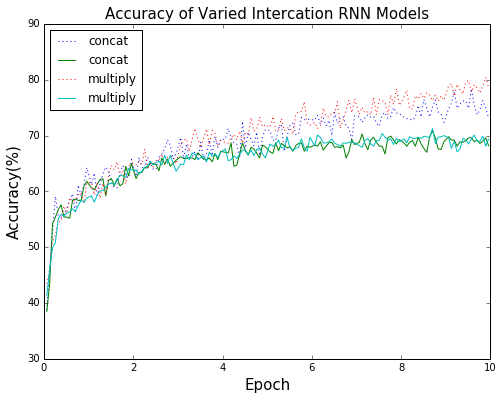

In [168]:
# plotting accuarcy rnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_gru_type:
    train_acc = val_acc_dict_gru_type[key]['train_acc']
    val_acc = val_acc_dict_gru_type[key]['val_acc']
    epoch = val_acc_dict_gru_type[key]['epoch']
    plt.plot( epoch, train_acc, ":", label=key)
    plt.plot( epoch, val_acc,"-", label=key)
plt.legend(loc='best')
plt.title('Accuracy of Varied Intercation RNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy(%)', size=15)

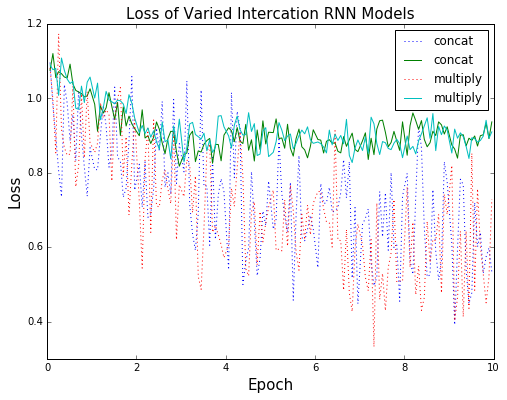

In [169]:
# plotting loss rnn
plt.figure(figsize=(8, 6))
for key in val_acc_dict_gru_type:
    train_acc = val_acc_dict_gru_type[key]['train_loss']
    val_acc = val_acc_dict_gru_type[key]['val_loss']
    epoch = val_acc_dict_gru_type[key]['epoch']
    plt.plot(epoch, train_acc,  ":", label=key)
    plt.plot(epoch, val_acc,  "-", label=key)
plt.legend(loc='best')
plt.title('Loss of Varied Intercation RNN Models', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)

In [39]:
def get_inncorrect(loader, model, model_type):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    cor_ind_list_s1 = []
    wrg_ind_list_s1 = []
    cor_ind_list_s2 = []
    wrg_ind_list_s2 = []
    cor_pred_list = []
    cor_truth_list = []
    wrg_pred_list = []
    wrg_truth_list = []
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels in loader:
        sen1_data_batch, sen2_data_batch, labels_batch = sen1_data, sen2_data, labels
        if model_type == 'rnn':
            outputs = model(sen1_data_batch, sen2_data_batch, sen1_lengths, sen2_lengths)
        elif model_type == 'cnn':
            outputs = model(sen1_data_batch, sen2_data_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        predicted = predicted.cpu()
        predicted = predicted.numpy()
        labels = labels.cpu()
        labels = labels.numpy()
        print(type(cor_ind_list_s1))
        print(type(labels))
        print(type(predicted))
        for i in range(len(outputs)):
            if (labels[i] == predicted[i]) & (len(cor_ind_list_s1) <3):
                cor_ind_list_s1.append(sen1_data_batch[i].numpy())
                cor_ind_list_s2.append(sen2_data_batch[i].numpy())
                cor_pred_list.append(predicted[i])
                cor_truth_list.append(labels[i])
            elif (labels[i] != predicted[i]) & (len(wrg_ind_list_s1) <3):
                wrg_ind_list_s1.append(sen1_data_batch[i].numpy())
                wrg_ind_list_s2.append(sen2_data_batch[i].numpy())
                wrg_pred_list.append(predicted[i])
                wrg_truth_list.append(labels[i])
            if (len(cor_ind_list_s1) == 3) & (len(wrg_ind_list_s1) == 3):
                break
        break
    for j in range(3):
        print('Correct Sentence Pair Prediction #{}'.format(j+1))
        print("Truth is {}, Prediction is {}".format(cor_truth_list[j], cor_pred_list[j]))
        for index in cor_ind_list_s1[j]:
            if index != 0:
                print(id2token[index], end=' ', flush=True)
        print()
        for index in cor_ind_list_s2[j]:
            if index != 0:
                print(id2token[index], end=' ', flush=True)
        print()
        
    for j in range(3):  
        print('Incorrect Sentence Pair Prediction #{}'.format(j+1))
        print("Truth is {}, Prediction is {}".format(wrg_truth_list[j], wrg_pred_list[j]))
        for index in wrg_ind_list_s1[j]:
            if index != 0:
                print(id2token[index], end=' ', flush=True)
        print()
        for index in wrg_ind_list_s2[j]:
            if index != 0:
                print(id2token[index], end=' ', flush=True)
        print()  

In [42]:
#mult RNN
num_epochs=10
model2 = GRU_mult(emb_size=300, hidden_size=50, num_classes=3, dropout=0, 
            embedding_array=embedding_array, fully_conn_size=200)
model2.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                    model=model2, test_model=test_model_loss, num_epochs=num_epochs, 
                                                    nn_type = 'rnn')

pytorch_total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(pytorch_total_params)

Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
232003


In [41]:
# Best Kernel
num_epochs=10
model = CNN(embd_size=300, hidden_size=500, num_classes=3, embedding_array=embedding_array, 
                    kernel_size=5, num_layers=2, fc_size=800)
model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch_list, val_acc_list, train_acc_list, val_loss_list, train_loss_list, val_acc = run_best_models(
                                                    model=model, test_model=test_model_cnn_loss, 
                                                    num_epochs=num_epochs,nn_type = 'cnn')

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)


Finished Epoch 1 of model
Finished Epoch 2 of model
Finished Epoch 3 of model
Finished Epoch 4 of model
Finished Epoch 5 of model
Finished Epoch 6 of model
Finished Epoch 7 of model
Finished Epoch 8 of model
Finished Epoch 9 of model
Finished Epoch 10 of model
3205203


In [ ]:
get_inncorrect(val_loader, model, model_type='cnn')

In [ ]:
get_inncorrect(val_loader, model2, model_type='rnn')

In [76]:
def tokenize_dataset_mnli(file):
    sen1_token_dataset_fiction = []
    sen2_token_dataset_fiction = []
    labels_fiction = []
    
    sen1_token_dataset_government = []
    sen2_token_dataset_government = []
    labels_government = []
    
    sen1_token_dataset_slate = []
    sen2_token_dataset_slate = []
    labels_slate = []
    
    sen1_token_dataset_travel = []
    sen2_token_dataset_travel = []
    labels_travel  = []

    sen1_token_dataset_telephone = []
    sen2_token_dataset_telephone = []
    labels_telephone  = []
    
    dataset = open(file, "r")
    next(dataset)
    for line in tqdm_notebook(dataset):
        sen1 = line.split("\t")[0]
        sen2 = line.split("\t")[1]
        topic = line.split("\t")[3].strip("\n")
        sen1_tokens = sen1.split()
        sen2_tokens = sen2.split()
        label = line.split("\t")[2]
        label = string_int_dict[label]
        if topic == 'fiction':
            sen1_token_dataset_fiction.append(sen1_tokens)
            sen2_token_dataset_fiction.append(sen2_tokens)
            labels_fiction.append(label)
        elif topic == 'government':
            sen1_token_dataset_government.append(sen1_tokens)
            sen2_token_dataset_government.append(sen2_tokens)
            labels_government.append(label)
        elif topic == 'slate':
            sen1_token_dataset_slate.append(sen1_tokens)
            sen2_token_dataset_slate.append(sen2_tokens)
            labels_slate.append(label)
        elif topic == 'travel':
            sen1_token_dataset_travel.append(sen1_tokens)
            sen2_token_dataset_travel.append(sen2_tokens)
            labels_travel.append(label)
        elif topic == 'telephone':
            sen1_token_dataset_telephone.append(sen1_tokens)
            sen2_token_dataset_telephone.append(sen2_tokens)
            labels_telephone.append(label)
    return (sen1_token_dataset_fiction,
        sen2_token_dataset_fiction,
        labels_fiction,
        sen1_token_dataset_government,
        sen2_token_dataset_government,
        labels_government,
        sen1_token_dataset_slate,
        sen2_token_dataset_slate,
        labels_slate,    
        sen1_token_dataset_travel,
        sen2_token_dataset_travel,
        labels_travel, 
        sen1_token_dataset_telephone,
        sen2_token_dataset_telephone,
        labels_telephone)

In [77]:
(sen1_token_dataset_fiction,
        sen2_token_dataset_fiction,
        labels_fiction,
        sen1_token_dataset_government,
        sen2_token_dataset_government,
        labels_government,
        sen1_token_dataset_slate,
        sen2_token_dataset_slate,
        labels_slate,    
        sen1_token_dataset_travel,
        sen2_token_dataset_travel,
        labels_travel, 
        sen1_token_dataset_telephone,
        sen2_token_dataset_telephone,
        labels_telephone) = tokenize_dataset_mnli(m_val_file)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [78]:
fiction_sen1_token_indices = token2index_dataset(sen1_token_dataset_fiction)
fiction_sen2_token_indices = token2index_dataset(sen2_token_dataset_fiction)
government_sen1_token_indices = token2index_dataset(sen1_token_dataset_government)
government_sen2_token_indices = token2index_dataset(sen2_token_dataset_government)
slate_sen1_token_indices = token2index_dataset(sen1_token_dataset_slate)
slate_sen2_token_indices = token2index_dataset(sen2_token_dataset_slate)
travel_sen1_token_indices = token2index_dataset(sen1_token_dataset_travel)
travel_sen2_token_indices = token2index_dataset(sen2_token_dataset_travel)
telephone_sen1_token_indices = token2index_dataset(sen1_token_dataset_telephone)
telephone_sen2_token_indices = token2index_dataset(sen2_token_dataset_telephone)

In [79]:
fiction_dataset = two_sentence_dataset(fiction_sen1_token_indices, fiction_sen2_token_indices, labels_fiction)
fiction_loader = torch.utils.data.DataLoader(dataset=fiction_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [80]:
government_dataset = two_sentence_dataset(government_sen1_token_indices, government_sen2_token_indices, labels_government)
government_loader = torch.utils.data.DataLoader(dataset=government_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [81]:
slate_dataset = two_sentence_dataset(slate_sen1_token_indices, slate_sen2_token_indices, labels_slate)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [82]:
travel_dataset = two_sentence_dataset(travel_sen1_token_indices, travel_sen2_token_indices, labels_travel)
travel_loader = torch.utils.data.DataLoader(dataset=travel_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [83]:
telephone_dataset = two_sentence_dataset(telephone_sen1_token_indices, telephone_sen2_token_indices, labels_telephone)
telephone_loader = torch.utils.data.DataLoader(dataset=telephone_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=two_sentence_collate_func,
                                           shuffle=False)

In [84]:
# test model function to run through whole mnli dataset, not just 1k
def test_model_mnli(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen2_lengths, labels in loader:
        sen1_data_batch, sen1_lengths_batch = sen1_data, sen1_lengths
        sen2_data_batch, sen2_lengths_batch, labels_batch = sen2_data, sen2_lengths, labels
        outputs = model(sen1_data_batch, sen2_data_batch, sen1_lengths_batch, sen2_lengths_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
    return (100 * correct / total)

def test_model_cnn_mnli(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sen1_data, sen1_lengths, sen2_data, sen1_lengths, labels in loader:
        sen1_data_batch, sen2_data_batch, labels_batch = sen1_data.cuda(), sen2_data.cuda(), labels
        outputs = model(sen1_data_batch, sen2_data_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).cuda()).sum().item()
    return (100 * correct / total)

In [86]:
# test rnn model on all MNLI loaders
# cnn is model
# rnn is model2
loader_list = [fiction_loader, government_loader, slate_loader, travel_loader, telephone_loader]
loader_strings = ['fiction_loader', 'government_loader', 'slate_loader', 'travel_loader', 'telephone_loader']
# RNN
print(model2)
for loader,string in list(zip(loader_list,loader_strings)):
    print(string)
    print(str(test_model_mnli(loader, model2)))
    
# CNN   
print(model)
for loader,string in list(zip(loader_list,loader_strings)):
    print(string)
    print(str(test_model_cnn_mnli(loader, model)))


GRU_mult(
  (embedding): Embedding(50002, 300)
  (GRU_s1): GRU(300, 50, batch_first=True, bidirectional=True)
  (GRU_s2): GRU(300, 50, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=3, bias=True)
)
fiction_loader
44.72361809045226
government_loader
43.60236220472441
slate_loader
43.51297405189621
travel_loader
44.806517311608964
telephone_loader
42.08955223880597
CNN(
  (embedding): Embedding(50002, 300)
  (conv1_s1): Conv1d(300, 500, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_s2): Conv1d(300, 500, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2_s1): Conv1d(500, 500, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2_s2): Conv1d(500, 500, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear1): Linear(in_features=1000, out_features=800, bias=True)
  (linear2): Linear(in_features=800, out_features=3, bias=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, pa